In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this mini project we are doing the Disaster Tweet challenge - we want to predict whether a Tweet is referring to a real disaster or not. https://www.kaggle.com/competitions/nlp-getting-started<br>
We will utilise exploratory data analysis, transform the text a bit, and build an LSTM model to predict whether a tweet is about a real disaster! This fun project will also include some hyperparameter tuning.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Let us read the Kaggle CSV files we mounted from Google Drive, and analyse them.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


There seems to be a lot of null values, so as our first data cleaning part we will count and then drop them.

In [ ]:
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [ ]:
train_df = train_df.dropna()
train_df = train_df.reset_index()
train_df

,index,id,keyword,location,text,target
0,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
2,33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
4,35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...,...
5075,7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
5076,7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
5077,7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
5078,7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


We don't know what the actual distribution of classes is, so let us see what it is on our train data, and normalize this so there is an equal amount of both target classes (is and is not a disaster).

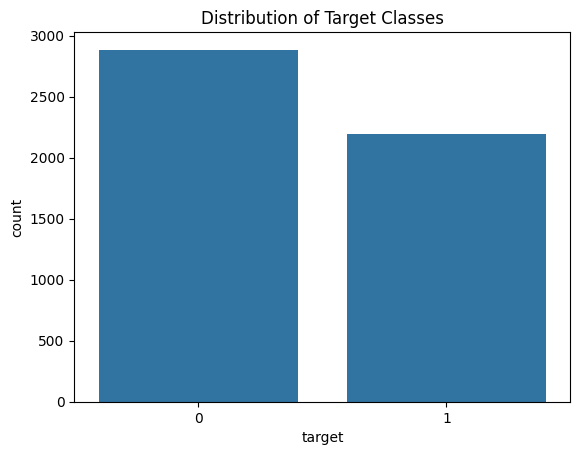

In [ ]:
# Plot class distribution
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Classes')
plt.show()

In [ ]:
min_count = train_df['target'].value_counts().min()
train_df_bal = pd.concat([
    train_df[train_df['target'] == 0].sample(min_count, random_state=42),
    train_df[train_df['target'] == 1].sample(min_count, random_state=42)
])
train_df_bal = train_df_bal.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_bal

,index,id,keyword,location,text,target
0,1172,1689,bridge%20collapse,"Mumbai , India",Warne shocked over Australia's epic collapse a...,1
1,3826,5444,first%20responders,Michigan,Kirsten Gillibrand http://t.co/amEA3LaMDj E...,1
2,5848,8356,ruin,Garrett,like why on earth would you want anybody to be...,0
3,1851,2661,crush,"Cleveland, Ohio",My woman crush wedneday goes to the beautiful ...,0
4,5545,7910,rainstorm,"Gloucester, MA",Rainstorm downtown Gloucester\n#gloucester #ca...,1
...,...,...,...,...,...,...
4387,7306,10456,wild%20fires,planet earth,@cnni @PrisonPlanet Climate Change CNN weather...,1
4388,566,818,battle,Wisconsin,@SexyDragonMagic I've come to the realization ...,0
4389,2757,3960,devastation,United States,70 Years After Atomic Bombs Japan Still Strugg...,1
4390,3644,5193,fatalities,oman muscat al seeb,I liked a @YouTube video http://t.co/43sXG9Z6x...,1


After balancing we visualize to check if everything is in order - the two columns should be of same height.

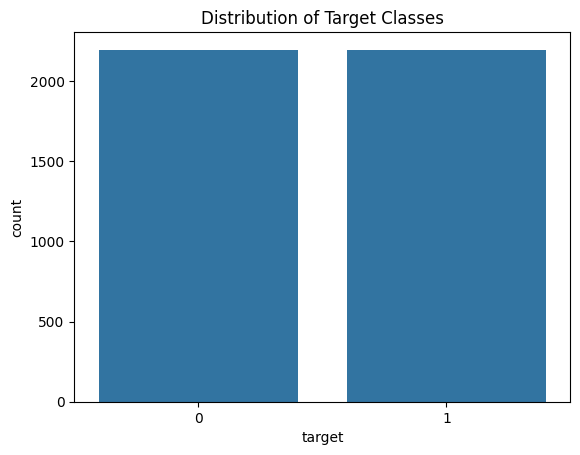

In [ ]:
# Plot class distribution for balanced data
sns.countplot(x='target', data=train_df_bal)
plt.title('Distribution of Target Classes')
plt.show()

Okay, after this we will clean the texts by removing links (so anything that starts with http). Also, we will remove mentions (that begin with @) because they contain random information about usernames. Finally, we remove numbers and punctuation as it does not carry meaningful information for language processing.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

train_df_bal['clean_text'] = train_df_bal['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

train_df_bal

,index,id,keyword,location,text,target,clean_text
0,1172,1689,bridge%20collapse,"Mumbai , India",Warne shocked over Australia's epic collapse a...,1,warne shocked over australias epic collapse at...
1,3826,5444,first%20responders,Michigan,Kirsten Gillibrand http://t.co/amEA3LaMDj E...,1,kirsten gillibrand extend health care to ...
2,5848,8356,ruin,Garrett,like why on earth would you want anybody to be...,0,like why on earth would you want anybody to be...
3,1851,2661,crush,"Cleveland, Ohio",My woman crush wedneday goes to the beautiful ...,0,my woman crush wedneday goes to the beautiful
4,5545,7910,rainstorm,"Gloucester, MA",Rainstorm downtown Gloucester\n#gloucester #ca...,1,rainstorm downtown gloucester\n
...,...,...,...,...,...,...,...
4387,7306,10456,wild%20fires,planet earth,@cnni @PrisonPlanet Climate Change CNN weather...,1,climate change cnn weather specialist warnin...
4388,566,818,battle,Wisconsin,@SexyDragonMagic I've come to the realization ...,0,ive come to the realization that i just dont ...
4389,2757,3960,devastation,United States,70 Years After Atomic Bombs Japan Still Strugg...,1,years after atomic bombs japan still struggle...
4390,3644,5193,fatalities,oman muscat al seeb,I liked a @YouTube video http://t.co/43sXG9Z6x...,1,i liked a video tremor is no joke tremor dlc...


We are going to use an OOV tokenizer to replace out-of-vocab words and to tokenize our texts, getting them ready as features for our NLP pipeline.

In [ ]:
# Parameters
vocab_size = 20000
max_length = 100
embedding_dim = 64
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df_bal['clean_text'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(train_df_bal['clean_text'])
X = pad_sequences(X, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_final = tokenizer.texts_to_sequences(test_df['clean_text'])
X_test_final = pad_sequences(X_test_final, maxlen=max_length, padding=padding_type)

y = train_df_bal['target'].values

X

array([[2188, 2189,   58, ...,    0,    0,    0],
       [4323, 4324, 4325, ...,    0,    0,    0],
       [  26,  114,   10, ...,    0,    0,    0],
       ...,
       [ 138,   37,  195, ...,    0,    0,    0],
       [   8,  329,    3, ...,    0,    0,    0],
       [  19,  372,  222, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Train/val split - standard procedure
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


We use an architecure that includes an embedding of text, and then a bidirectional LSTM (examines text from left to right, and from right to left to catch extra meaning).<br>
We also have a droupout layer with a hyperparameter we tune.<br>
We also tune the units parameter of our LSTM. We choose reasonable values and perform grid search.

In [ ]:
from sklearn.metrics import f1_score

def build_model(lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

models = []
# grid hyperparemeter search for lstm units and dropout percentage

for units in {32, 64, 128, 256}:
  for drpo in {0.25, 0.5, 0.75}:
    models.append((units,drpo,build_model(units, drpo)))

print(models)

[(32, 0.25, <Sequential name=sequential_48, built=False>), (32, 0.5, <Sequential name=sequential_49, built=False>), (32, 0.75, <Sequential name=sequential_50, built=False>), (256, 0.25, <Sequential name=sequential_51, built=False>), (256, 0.5, <Sequential name=sequential_52, built=False>), (256, 0.75, <Sequential name=sequential_53, built=False>), (64, 0.25, <Sequential name=sequential_54, built=False>), (64, 0.5, <Sequential name=sequential_55, built=False>), (64, 0.75, <Sequential name=sequential_56, built=False>), (128, 0.25, <Sequential name=sequential_57, built=False>), (128, 0.5, <Sequential name=sequential_58, built=False>), (128, 0.75, <Sequential name=sequential_59, built=False>)]


TensorFlow will work with GPU for faster training

In [ ]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2.18.0
Num GPUs Available: 1


Here we run all the models and compare based on the metric used in Kaggle - the F1 score.

In [ ]:
best_tuple = None
best_f1 = 0

for units, drpo, model in models:
  model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    verbose=1
  )
  val_preds = (model.predict(X_val) > 0.5).astype("int32")
  f1 = f1_score(val_preds, y_val)
  if best_f1 < f1:
    best_f1 = f1
    best_tuple = (units, drpo, model)

print(f"Best f1 score is {best_f1} for hyperparameters: ")
print(best_tuple)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5378 - loss: 0.6911 - val_accuracy: 0.7144 - val_loss: 0.6601
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7527 - loss: 0.6093 - val_accuracy: 0.7531 - val_loss: 0.5227
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8442 - loss: 0.3602 - val_accuracy: 0.7486 - val_loss: 0.5438
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9341 - loss: 0.1935 - val_accuracy: 0.7406 - val_loss: 0.6211
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9672 - loss: 0.1072 - val_accuracy: 0.7497 - val_loss: 0.6714
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9732 - loss: 0.0852 - val_accuracy: 0.7600 - val_loss: 0.8176
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9806 - loss: 0.0558 - val_accuracy: 0.7327 - val_loss: 0.8457
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9796 - loss: 0.0549 - val_accuracy: 0.7235 - v

The best model was one with 32 as units count and a high dropout of 75%.
<br>Let us submit this to Kaggle (generate a CSV and download it)

In [ ]:
test_preds = (best_tuple[2].predict(X_test_final) > 0.5).astype("int32")

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds.reshape(-1)
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Submission file saved as submission.csv


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally, here is a screenshot of our position on the Leaderboard.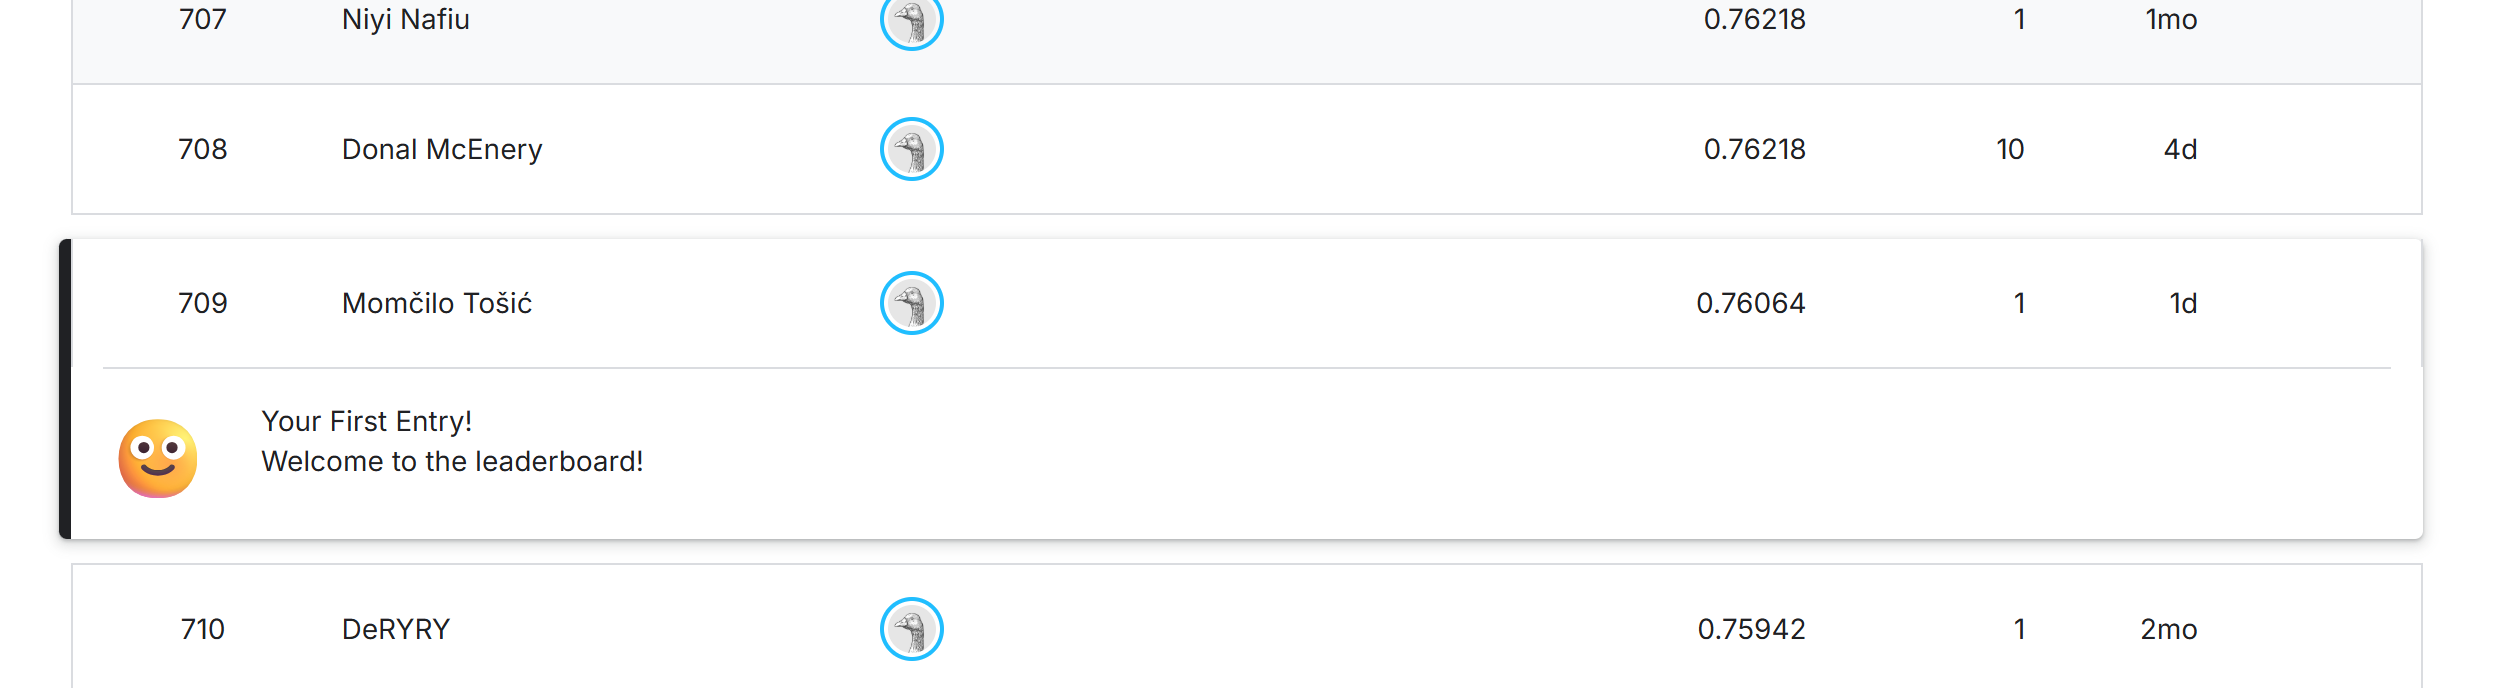